# [쇼핑몰 리뷰 평점 분류 경진대회](https://dacon.io/competitions/official/235938/overview/description)
- [Load Data](#load-data)
- [Data Augmentation](#data-augmentation)
- [Data Preprocess](#data-preprocess)
- [Modeling](#modeling)
- [Train](#train)
- [Evaluate](#evaluate)
- [Predict](#predict)
- [Submission](#submission)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Set, Callable, Optional

In [ ]:
import random
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## Load Data

In [ ]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')
print(train.shape)
train.head()

(25000, 3)


,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


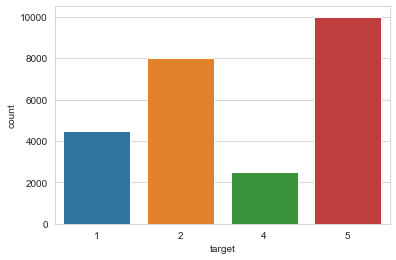

In [ ]:
sns.set_style('whitegrid')
sns.countplot(data=train, x='target')
plt.show()

평점 별 리뷰 수에 대한 시각화 결과 라벨 간 데이터 불균형이 존재하는 것을 확인   
데이터 증강을 통해 각 평점 간 비율을 맞춰야할 것이라 판단

## Data Augmentation
- 초기엔 googletrans를 통한 역번역을 시도했지만, 실제 웹에서 확인해본 결과와 달리 오번역이 많음
- NLPAUG 라이브러리도 시도하려 했지만, 한국어를 지원하지 않는 문제로 번역이 불가피함을 느낌
- googletrans 번역의 대안으로 API 및 웹 스크래핑을 활용한 번역을 시도,   
  구글 번역의 경우 셀레니움 환경에서도 동일한 오번역이 발생하는 문제로 파파고를 활용했고 유의미한 결과를 확인
- 다만, 크롤링의 경우 번역 결과를 확인하기 위해 딜레이를 줘야해서 시간의 소요가 클 것으로 예상,   
  네이버 클라우드 크레딧으로 감당가능한 범위 내에서 파파고 API를 활용

### Process
1. 파파고 API 및 웹 스크래핑을 활용해 한글 리뷰를 영어로 변환한 데이터프레임 생성
2. NLPAUG 라이브러리의 동의어 변형 기법을 활용해 랜덤한 문장을 필요한 수만큼 증강
3. 증강된 영문을 다시 파파고 API와 웹 스크래핑을 통해 역번역하여 리뷰 데이터에 추가

In [ ]:
import re
import nlpaug.augmenter.word as naw

from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import urllib
import time
from tqdm.notebook import tqdm

In [ ]:
service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

src, dest = 'ko', 'en'
translate_url = f'https://papago.naver.com/?sk={src}&tk={dest}'
train['translated'] = None
translated, errors = list(), list()

driver.get(translate_url)
time.sleep(3)

for i, review in enumerate(tqdm(train['reviews'])):
    try:
        driver.find_element(By.ID, 'txtSource').clear()
        driver.find_element(By.ID, 'txtSource').send_keys(review)
        time.sleep(np.sqrt(np.log(len(review)))+1)
        train['translated'][i] = driver.find_element(By.ID, 'txtTarget').text
    except:
        errors.append(i)

driver.close()

In [ ]:
sum(train['reviews'].isna())

80


크롤링 중 딜레이가 충분하지 않아 이전에 번역된 문장이 저장되거나, 이모티콘 등으로 인해 번역이 올바르게 진행되지 않은 경우를 확인   
해당하는 행들을 추출하여 파파고 API를 통해 한영 번역 시도

In [ ]:
def papago_translate(df: pd.DataFrame, source_col: str, target_col: str,
                    source='ko', target='en', indices: Optional[List[int]]=None) -> pd.DataFrame:

    headers = {
    'X-NCP-APIGW-API-KEY-ID': 'YOUR_CLIENT_ID',
    'X-NCP-APIGW-API-KEY': 'YOUR_CLIENT_SECRET'
    }
    url = 'https://naveropenapi.apigw.ntruss.com/nmt/v1/translation'

    data = df.iloc[indices].copy() if indices else df.copy()
    indices = data.index.tolist() if not indices else indices
    sentences = data[source_col].tolist()
    errors = dict()

    for idx, sentence in tqdm(zip(indices, sentences), total=len(sentences)):
        params = f'source={source}&target={target}&text=' + urllib.parse.quote(sentence)
        request = urllib.request.Request(url, headers=headers)
        response = urllib.request.urlopen(request, data=params.encode('utf-8'))
        rescode = response.getcode()
        if rescode == 200:
            response_body = response.read().decode('utf-8')
            translated = re.search('"translatedText":"(.+?)"', response_body).group(1)
            data[target_col][idx] = translated.encode('utf-8', 'ignore').decode('utf-8').strip()
        else:
            errors[idx] = rescode

    if errors:
        print('Errors occured:', errors)

    return data

In [ ]:
duplicated_rows = train['translated'].duplicated()
null_rows = train['translated'].isna()
short_rows = train['translated'].str.len() < 15

untranslated = train[duplicated_rows|null_rows|short_rows].index.tolist()
train.iloc[untranslated] = papago_translate(train, 'reviews', 'translated', indices=untranslated)

In [ ]:
train['translated'] = train['translated'].apply(lambda x: re.sub('[^A-Za-z0-9\'\"\.,!\?\^:\(\)~\s]','',x).strip())
train['translated'] = train['translated'].apply(lambda x: re.sub('\.{3,}','...',x))
train['translated'] = train['translated'].apply(lambda x: re.sub('\s+',' ',x))

번역 결과를 검증하기 위해 의미없는 문자를 모두 제거

In [ ]:
train[train['translated'].str.len() <= 5]

,id,reviews,target,translated
10548,10548,굿 저렴해요 ㅂㄷㄴㄱㅈㄴㄷㅇㄴㅂㅈㄱㅈㄷㅎㅇㅈㅂㄷㄹㅇㅅㅇㄷㄱㄴㄱㅈㄷㅅㄴㅇㅈㄱㄷㄱㄷㅅㅈ...,5,
20137,20137,잘받았습니다 ㄷㄱㄷㄴㅇ짖ㄷㄱㅅㄱㅇㅈ은ㄱㅎㅂ지ㅡㄴㅇㄴㅅㄱㄷㅂㅈㅅㄱㄷㅇㄷㄴㄱㄷㅈㄱㄷ림ㅂ...,2,
20777,20777,ㅂㄷㄱㄷㄱ ㄴㅋㅌㄱㅈㅋㄷㅂㄷㄱㅈㄷㅂㄷㅂㅈㅂㄷㅂㄷㄱㅈ극ㄷㄱㄷㅂㄷㅂㅈㄱㄷㄱㅈㅂㄷㄱㅈ긎ㄱ...,5,
21034,21034,ㅎㅇㄴㅁㅎㅇㄴㅁㅎㅇㄴㅁ ㅎㅇㄴㅁㅎㅁㄴ애ㅔ혀ㅓㅔ;ㅇㅁ로ㅕㅐ;ㄹㅇ마ㅓ;힘ㅇ넣ㅁㄴㅇㅎㅇㄴ...,5,
21117,21117,ㅂㄷ로ㅗㅜㅜㅡ,2,
22916,22916,ㄱㆍㄷㄱㄴㅈㄱㅅㅈㅂㄴㄷㅂ늡ㄴ ㄴㅈㅂㄴㄷㄱㆍㄷㅂㄴㅈㅂㄴㄷ곡ㄴㅈㅂㄴㄷㅂㆍㄷㄱㆍㄷ악ㄴㄷㄱ...,2,


검증 후에도 여전히 번역되지 않는 리뷰를 확인했을 때, 노이즈 데이터로 이루어진 것을 확인하고 해당 행들을 제거

In [ ]:
train = train[train['translated'].str.len() > 5]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24994 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          24994 non-null  int64 
 1   reviews     24994 non-null  object
 2   target      24994 non-null  int64 
 3   translated  24994 non-null  object
dtypes: int64(2), object(2)
memory usage: 976.3+ KB


In [ ]:
train['target'].value_counts()

5    9997
2    7997
1    4500
4    2500
Name: target, dtype: int64

가장 수가 많은 평점 5점 리뷰 수에 맞춰 역번역할 문장을 수집 후 파파고 API를 통해 번역   
2배 이상의 증강이 필요할 경우 우선적으로 NLPAUG 라이브러리의 동의어 변환 기법을 적용

In [ ]:
def add_synonyms(sentences: Set[str], num_aug: int) -> List[str]:
    aug = naw.SynonymAug()
    while len(sentences) < num_aug:
        augmented = [aug.augment(sentence)[0] for sentence in sentences]
        sentences.update(set(augmented))
    return random.sample(sentences, num_aug)

def nlpaug(sentences: List[str], num_aug: int) -> List[str]:
    sentences = set(sentences)
    try:
        return random.sample(sentences, num_aug)
    except ValueError:
        return add_synonyms(sentences, num_aug)

In [ ]:
aug_df = pd.DataFrame({'translated':list(),'target':list()})
counts = train['target'].value_counts()

for target in train['target'].unique():
    target_df = train[train['target'] == target]
    num_aug = counts.max() - counts[target]
    result = nlpaug(target_df['translated'].tolist(), num_aug)

    if result:
        result_df = pd.DataFrame({'translated':result,'target':target})
        aug_df = pd.concat([aug_df,result_df], ignore_index=True).reset_index(drop=True)

aug_df['reviews'] = None
aug_df = papago_translate(aug_df, 'translated', 'reviews', source='en', target='ko')

In [ ]:
train = pd.concat([train,aug_df], ignore_index=True).drop('translated',axis=1)
print(train.shape)
train['target'].value_counts()

(39988, 3)


2.0    9997
1.0    9997
5.0    9997
4.0    9997
Name: target, dtype: int64

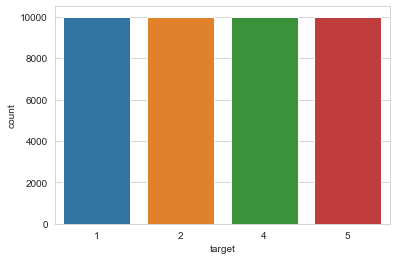

In [ ]:
sns.set_style('whitegrid')
sns.countplot(data=train, x='target')
plt.show()

평점 별 데이터가 균등하게 분포된 것을 확인

In [ ]:
train['id'] = train.index
train['target'] = train['target'].astype('int64')
train.to_csv('./data/train_aug.csv', index=False)
train = pd.read_csv('./data/train_aug.csv')

## Data Preprocess

In [ ]:
import re
from hanspell import spell_checker
from soynlp.normalizer import emoticon_normalize, only_text

In [ ]:
def preprocess_sentences(df: pd.DataFrame, column: str) -> pd.DataFrame:
    data = df.copy()
    errors = list()

    data[column] = data[column].apply(lambda x: re.sub('\.*!+', '!', x))
    data[column] = data[column].apply(lambda x: re.sub('\.*\?+', '?', x))
    data[column] = data[column].apply(lambda x: re.sub(',+', ',', x))
    data[column] = data[column].apply(lambda x: re.sub('(,\.|\.,)', '..', x))
    data[column] = data[column].apply(lambda x: re.sub('\.{2,}', '...', x))
    data[column] = data[column].apply(lambda x: re.sub('[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣\s\[\]\.,!\?\"\']', '', x))
    data[column] = data[column].apply(lambda x: emoticon_normalize(only_text(x)))

    for i,review in tqdm(zip(data.index.tolist(),data[column].tolist()), total=len(data)):
        try:
            train[column][i] = spell_checker.check(review).checked
        except:
            errors.append(i)

    return data

문장에 연속되는 문자를 제거하고 최대한 일반적인 표현으로 변환

In [ ]:
train = preprocess_sentences(train, 'reviews')
test = preprocess_sentences(test, 'reviews')
train.to_csv('./data/train_aug_cleaned.csv', index=False)
test.to_csv('./data/test_cleaned.csv', index=False)

## Modeling

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback, TrainingArguments, Trainer
from transformers.tokenization_utils_base import BatchEncoding
from transformers.trainer_utils import EvalPrediction
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from sklearn.metrics import accuracy_score

In [ ]:
MAX_LEN = 128
VALID_SPLIT = 0.1
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 1e-5
DR_RATE = 0.3
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01
METRIC = 'accuracy'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('mps')
MODEL_NAME = 'koelectra'
MODEL_PATH = 'jaehyeong/koelectra-base-v3-generalized-sentiment-analysis'

### Load Datasets

In [ ]:
train = pd.read_csv('./data/train_aug_cleaned.csv')
LABELS = [1,2,4,5]
id2label = {idx:label for idx, label in enumerate(LABELS)}
label2id = {label:idx for idx, label in enumerate(LABELS)}
print(train.shape)
train.head()

(39988, 3)


,id,reviews,target
0,0,좋아요 처음 구입 싸게 했어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천 원가량 주고 사기 너무...,1
2,2,디자인은 괜찮은데 상품이 금이 가서 교환했는데 두 번째 받은 상품도 까져있고 안쪽에...,2
3,3,기전에 이 제품 말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. ...,2
4,4,튼튼하고 손목을 잘 받쳐주네요,5


In [ ]:
train_dataset = load_dataset('csv', data_files='./data/train_aug_cleaned.csv', split='train')
test_dataset = load_dataset('csv', data_files='./data/test_cleaned.csv', split='train')
train_dataset = train_dataset.train_test_split(test_size=VALID_SPLIT)
clear_output()
print(train_dataset['train'].shape, train_dataset['test'].shape, test_dataset.shape)

(22500, 3) (2500, 3) (25000, 2)


### Tokenization

In [ ]:
def tokenize(model_path: str) -> Callable[[Dataset],BatchEncoding]:
    tokenizer = AutoTokenizer.from_pretrained(model_path, problem_type='multi_label_classification')
    clear_output()
    return lambda examples: tokenizer(examples['reviews'], max_length=MAX_LEN, padding='max_length', truncation=True)

def one_hot(examples: Dataset) -> Dict[str,np.ndarray]:
    return {'labels':np.eye(len(LABELS))[label2id[examples['target']]]}

def preprocess(data: Dataset, model_path: str, labeled=True) -> Dataset:
    encoded = data.map(tokenize(model_path), batched=True, remove_columns=['id','reviews'], load_from_cache_file=False)
    encoded = encoded.map(one_hot, remove_columns=['target'], load_from_cache_file=False) if labeled else encoded
    encoded.set_format('torch')
    return encoded

### Load Model

In [ ]:
def model(model_path: str) -> AutoModelForSequenceClassification:
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        problem_type='multi_label_classification',
        ignore_mismatched_sizes=True,
        num_labels=len(LABELS),
        id2label=id2label,
        label2id=label2id,).to(device)
    clear_output()

    return model

In [ ]:
def compute_metrics(p: EvalPrediction) -> Dict[str,float]:
    predictions, labels = p
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(labels, axis=1)
    return {
        'accuracy': accuracy_score(y_true=y_true, y_pred=y_pred),
    }

### Load Trainer

In [ ]:
def make_dirs(name: str) -> Dict[str,str]:
    required_dirs = {
        'root':'./saved','model_root':'./saved/models','model_dir':f'./saved/models/{name}',
        'logging_root':'./saved/logger','logging_dir':f'./saved/logger/{name}'}
    for dir in required_dirs.values():
        if not os.path.isdir(dir):
            os.mkdir(dir)
    return required_dirs

def training_args(model_name: str) -> TrainingArguments:
    required_dirs = make_dirs(model_name)
    return TrainingArguments(
        output_dir=required_dirs['model_dir'],
        evaluation_strategy='epoch',
        save_strategy='epoch',
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        warmup_steps=WARMUP_STEPS,
        weight_decay=WEIGHT_DECAY,
        logging_dir=required_dirs['logging_dir'],
        load_best_model_at_end=True,
        metric_for_best_model=METRIC,
    )

def trainer(dataset: Dataset, model_name: str, model_path: str, labeled=True) -> Trainer:
    data_loader = preprocess(dataset, model_path, labeled)

    return Trainer(
        model=model(model_path),
        args=training_args(model_name),
        train_dataset=data_loader['train'],
        eval_dataset=data_loader['test'],
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(3)],
    )

In [ ]:
koelectra_trainer = trainer(train_dataset, MODEL_NAME, MODEL_PATH)

## Train

In [ ]:
koelectra_trainer.train()

## Evaluate

In [ ]:
koelectra_trainer.evaluate()

## Predict

In [ ]:
test_dataset = preprocess(test_dataset, MODEL_PATH, labeled=False)
result = koelectra_trainer.predict(test_dataset)
preds = np.vectorize(id2label.get)(np.argmax(result.predictions, axis=1))

## Submission

In [ ]:
submission.target = preds
submission.head()

In [ ]:
submission.to_csv('./data/samples/submission.csv', index=False)